# MyTorch Tutorial

The purpose of this tutorial is to illustrate the capabilities of MyTorch. In particular, we will use MyTorch to construct and train a simple feedforward MNIST image classifier.

In [1]:
import mytorch
import os
import matplotlib.pyplot as plt

Let's start by loading the datasets. The training set contains 60,000 images of handwritten digits along with their labels, while the test set contains 10,000 image/label pairs. 

In [2]:
train_set = mytorch.data.MNIST(os.getcwd(), train=True)
test_set = mytorch.data.MNIST(os.getcwd(), train=False)

Let's print a few images and their target labels.

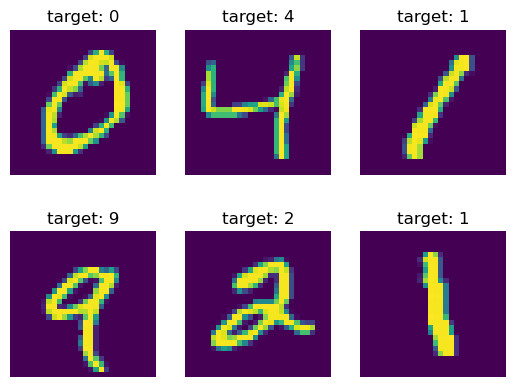

In [3]:
fig = plt.figure()
for i in range(1,7):
    fig.add_subplot(2,3,i)
    image, label = train_set[i]
    plt.imshow(image.data)
    plt.title(f'target: {label.data}')
    plt.axis('off')

Next we'll use the datasets to construct DataLoader objects, which are iterables over batches of data. In the case of MNIST, each batch will consist of a tuple (images,labels). We'll use a batch size of 16 and shuffle the data after every epoch.

In [4]:
train_loader = mytorch.data.DataLoader(train_set, batch_size=16, shuffle=True)
test_loader = mytorch.data.DataLoader(train_set, batch_size=64, shuffle=True)

Now let's define a feedforward neural network to classify the images. We'll use a 3 layer network:
- Input layer: 28 x 28 = 784 nodes
- Hidden layer: 128 nodes
- Output layer: 10 nodes (for 10 classes)  

along with ReLU activation functions for the hidden units. We leave the output units unnormalized, because a softmax layer is built into the cross entropy cost function that we will use.

In [5]:
class Network(mytorch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.layer_stack = mytorch.nn.Sequential(
            mytorch.nn.Flatten(),
            mytorch.nn.Linear(28 * 28, 128),
            mytorch.nn.ReLU(),
            mytorch.nn.Linear(128, 10)
        )

    def forward(self, input):
        return self.layer_stack(input)
    
net = Network()

As expected, the randomly initialized network makes poor classification predictions:

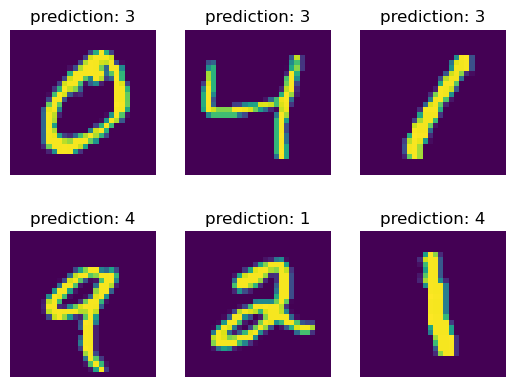

In [6]:
fig = plt.figure()
batch = next(iter(test_loader))
for i in range(1,7):
    fig.add_subplot(2,3,i)
    image = batch[0][i]
    pred = net(image[None,...]).argmax()
    plt.imshow(image.data)
    plt.title(f'prediction: {pred.data}')
    plt.axis('off')

Let us now train the the network so that it can make better predictions. We will use a cross entropy cost function and a vanilla stochastic gradient descent optimization algorithm.

In [7]:
cost_fn = mytorch.nn.CrossEntropyLoss()
optimizer = mytorch.optim.SGD(
    net.parameters(),
    lr=0.001,
    momentum=0.9,
    dampening=0,
    weight_decay=0
)

Define a function which tests the performance of the network by evaluating it on the test set:

In [8]:
def test():
    total = len(test_loader) * test_loader.batch_size
    correct = 0

    # Loop over mini-batches
    for images, targets in test_loader:
        # Network output and class prediction
        output = net(images)
        class_preds = output.argmax(dim=1)

        # Update correct count
        correct += (class_preds == targets).sum(dim=0).data
    
    return correct / total

print(f'Initial classification accuracy: {test():.1%}.')

Initial classification accuracy: 8.5%.


Define a function which trains the network for a single epoch:

In [9]:
def train():
    # Loop over mini-batches
    for images, targets in train_loader:
        # Network output
        output = net(images)

        # Loss
        loss = cost_fn(output, targets)

        # Clear previous gradients
        optimizer.zero_grad()

        # Backpropagate to get new gradients
        loss.backward()
        
        # Perform optimizer step
        optimizer.step()

Now we implement a loop over epochs. During each epoch we train the model, monitor its performance on the test set, and terminate training when the test error doesn't significantly decrease for a specified number of consecutive epochs. 

In [10]:
import time

min_epochs = 5                 # minimum training epochs
starting_patience = 5          # number of epochs of leniency
tolerance = 0.01               # required improvement in classification accuracy

epoch = 0                      # epoch counter
accuracies = []                # classification accuracies on test set
best_accuracy = 0              # best accuracy so far (within tolerance)
patience = starting_patience   # patience counter
print_interval = 1             # when to print progress

print('MyTorch Network:')

start_time = time.perf_counter()

while epoch < min_epochs or patience > 0:

    epoch += 1

    # Train
    train()

    # Test and record accuracy
    accuracy = test()
    accuracies.append(accuracy)

    # Compare to best_accuracy and decrease or reset patience
    if accuracy > best_accuracy + tolerance:
        best_accuracy = accuracy
        patience = starting_patience
    else:
        patience -= 1

    # Print progress
    if epoch % print_interval == print_interval - 1:
        print(f'Epoch {epoch:3d}: accuracy = {accuracy:3.2%}')
    if patience == 0:
        if epoch % print_interval != print_interval - 1:
            print(f'Epoch {epoch:3d}: accuracy = {accuracy:3.2%}')
        print('Ran out of patience.')

total_epochs = epoch

end_time = time.perf_counter()
train_time = end_time - start_time
print(f'Training time: {int(train_time)} seconds')

MyTorch Network:
Epoch   1: accuracy = 89.94%
Epoch   2: accuracy = 91.74%
Epoch   3: accuracy = 93.10%
Epoch   4: accuracy = 94.04%
Epoch   5: accuracy = 94.76%
Epoch   6: accuracy = 95.32%
Epoch   7: accuracy = 95.80%
Epoch   8: accuracy = 96.14%
Epoch   9: accuracy = 96.43%
Epoch  10: accuracy = 96.68%
Epoch  11: accuracy = 96.88%
Epoch  12: accuracy = 97.07%
Epoch  13: accuracy = 97.23%
Epoch  14: accuracy = 97.39%
Epoch  15: accuracy = 97.50%
Epoch  16: accuracy = 97.62%
Ran out of patience.
Training time: 153 seconds


After 153 seconds of training, our MyTorch network can classify MNIST images with 97.6% accuracy! For comparison, let's construct a PyTorch network with the same architecture and train it using the same optimization algorithm and the same hyperparameters. We will train it for the same number of epochs as our MyTorch Network, so that we can compare the training times.

In [13]:
import torch
import torchvision

# Datasets
transform = torchvision.transforms.ToTensor()
py_train_set = torchvision.datasets.MNIST(
    os.getcwd(), train=True, transform=transform, download=True)
py_test_set = torchvision.datasets.MNIST(
    os.getcwd(), train=False, transform=transform, download=True)

# Dataloaders
py_train_loader = torch.utils.data.DataLoader(
    py_train_set, batch_size=16, shuffle=True)
py_test_loader = torch.utils.data.DataLoader(
    py_test_set, batch_size=64)

# Network
class PyNetwork(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.layer_stack = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(28 * 28, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 10)
        )

    def forward(self, input):
        return self.layer_stack(input)
    
pynet = PyNetwork()

# Cost and Optimizer
py_cost_fn = torch.nn.CrossEntropyLoss()
py_optimizer = torch.optim.SGD(
    pynet.parameters(),
    lr=0.001,
    momentum=0.9,
    dampening=0,
    weight_decay=0
)

# Test function
def py_test():
    total = len(py_test_loader) * py_test_loader.batch_size
    correct = 0

    # Loop over mini-batches
    for images, targets in py_test_loader:
        # Network output and class prediction
        output = pynet(images)
        class_preds = output.argmax(dim=1)

        # Update correct count
        correct += (class_preds == targets).sum().item()

    return correct / total

# Training function for single epoch
def py_train():
    # Loop over mini-batches
    for images, targets in py_train_loader:
        # Network output
        output = pynet(images)

        # Loss
        loss = py_cost_fn(output, targets)

        # Clear previous gradients
        py_optimizer.zero_grad()

        # Backpropagate to get new gradients
        loss.backward()
        
        # Perform optimizer step
        py_optimizer.step()

# Train
epoch = 0                      # epoch counter
accuracies = []                # classification accuracies on test set

print('PyTorch Network:')

start_time = time.perf_counter()

while epoch < total_epochs:

    epoch += 1

    # Train
    py_train()

    # Test and record accuracy
    accuracy = py_test()
    accuracies.append(accuracy)

    # Print progress
    if epoch % print_interval == print_interval - 1:
        print(f'Epoch {epoch:3d}: accuracy = {accuracy:3.2%}')

end_time = time.perf_counter()
train_time = end_time - start_time
print(f'Training time: {int(train_time)} seconds')

PyTorch Network:
Epoch   1: accuracy = 90.26%
Epoch   2: accuracy = 91.79%
Epoch   3: accuracy = 92.49%
Epoch   4: accuracy = 93.35%
Epoch   5: accuracy = 93.76%
Epoch   6: accuracy = 94.32%
Epoch   7: accuracy = 94.81%
Epoch   8: accuracy = 95.21%
Epoch   9: accuracy = 95.37%
Epoch  10: accuracy = 95.63%
Epoch  11: accuracy = 96.03%
Epoch  12: accuracy = 96.03%
Epoch  13: accuracy = 96.33%
Epoch  14: accuracy = 96.39%
Epoch  15: accuracy = 96.55%
Epoch  16: accuracy = 96.52%
Training time: 193 seconds


The PyTorch network achieves 96.5% classification accuracy, compared to 97.6% for our MyTorch network. Of course we expect the two nets to perform similarly, since they have the same architecture and were trained using the same algorithm. The difference between the two is solely due to their different (random) initial configurations, and the randomness associated with minibatch sampling during training.

What is somewhat more interesting is that the MyTorch training takes 27% less time than the PyTorch training (for the same number of epochs). It appears that the lightweight/minimalist implementation of MyTorch gives it a slight edge in performance over PyTorch in this simple example. 